**This jupyter notebook includes:**

1. Feature Extractor module using DenseNet
2. Function to Uniformly Sample the 20 frames from the Video
3. Function to create labeled dataset used for Supervsed learning

### importing the required modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
import os
from os.path import join
import cv2 as cv
%matplotlib inline

2022-12-05 21:31:28.385382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 21:31:28.530755: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-05 21:31:28.567795: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-05 21:31:29.056282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

### Defining the path directory

In [2]:
paths={'dataset':join('../UCF-101/'),
'features':join('../features')}

In [3]:
## Creating the folder if the folder does not does not exist
for key,value in paths.items():
    if not os.path.exists(value):
        os.makedirs(value)
    else:
        print('{} folder already exists'.format(key))

dataset folder already exists
features folder already exists


### Defining some Parameters for creating trainable features 


In [4]:

classes=['WalkingWithDog','TaiChi','Swing','HorseRace'] ## action recogniton classes
seq_len=20 ## Number of samples used in each frame
resized_height,resized_width=128,128 ## image resizing parameters
num_features=1024 ## number of features output from DenseNet121

### Feature extraction with DenseNet121

In [28]:

def features_extraction_model(resized_height,resized_width):
    ## defining the DenseNet121 model pretrained with imagenet dataset
    feature_extractor=tf.keras.applications.DenseNet121(include_top=False,weights='imagenet',
                        pooling='avg',
                        input_shape=(resized_height,resized_width,3))
    ##Defining the input size for single image                    
    inputs=tf.keras.Input((resized_height,resized_width,3))
    preprocessed=tf.keras.applications.densenet.preprocess_input(inputs)

    ## Give features for each image
    outputs=feature_extractor(preprocessed)
    ## defining feature extractor model
    model=tf.keras.Model(inputs,outputs,name='feature_extractor')
    return model

In [36]:
feature_extractor=features_extraction_model(resized_height,resized_width)## initializing the feature extractor model

29084464/29084464 [==============================] - 4s 0us/step


In [38]:
feature_extractor.summary() ## Summary of the feature extractor model

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
Total params: 7,037,504
Trainable params: 6,953,8

### Creating Uniform samples of frames out of video

In [35]:
def extract_frames(video_dire): ## takes the directory of the video as input 
    extracted_frames=[] ## samples of images will be stored in this list
    video_reader=cv.VideoCapture(video_dire) ## Read the video
    total_frames=int(video_reader.get(cv.CAP_PROP_FRAME_COUNT)) ## get the total number of frames
    skip_frames=max(int(total_frames/seq_len),1) ## How many frames to skip ?
    for frame_counter in range(total_frames):
        video_reader.set(cv.CAP_PROP_POS_FRAMES,frame_counter*skip_frames)
        sucess,frame=video_reader.read()
        if not sucess:
            break
        resized_frame=cv.resize(frame,(resized_width,resized_height)) ## Resizing each image
        extracted_frames.append(resized_frame) 
        if len(extracted_frames)==seq_len: ## Checks if the lenght of the extracted frames is equal to seq_len(number of frames)
            break
    extracted_frames=np.array(extracted_frames)
    return extracted_frames  ## return extracted frames 

### Creating trainable features with respect to their levels

In [43]:
def create_dataset():

    labels=[] ## list to store labels 0,1,2,3
    features=[] # Store spatial-temporal features from each video
    for idx,className in enumerate(classes): ## iterate through each class and assign levels as idx
        video_dires_list=glob(join(paths['dataset'],className)+"/*.avi") ## Video dire for each class 
        for video_dire in video_dires_list: ## iterate video dire for each class
            extracted_frames=extract_frames(video_dire) ## Sampled the video to 20 frames and store the images
            if len(extracted_frames)==20:
                #print(1)
                get_features=feature_extractor.predict(extracted_frames) ## spatial temporal features
                features.append(get_features) ## appending features
                labels.append(idx) ## append labels
                
    return np.array(features),np.array(labels) ## return array of features and levels

In [44]:
features,labels=create_dataset()

1/1 [==============================] - 0s 16ms/step


### Saving the features and labels in numpy format

In [49]:
## saving the extracted features 
np.save(join(paths['features'],'features.npy'),features)
np.save(join(paths['features'],'labels.npy'),labels)

## Visualising the sample size of labels 

In [50]:
import seaborn as sns

<AxesSubplot:title={'center':'Number of videos for each class'}, ylabel='count'>

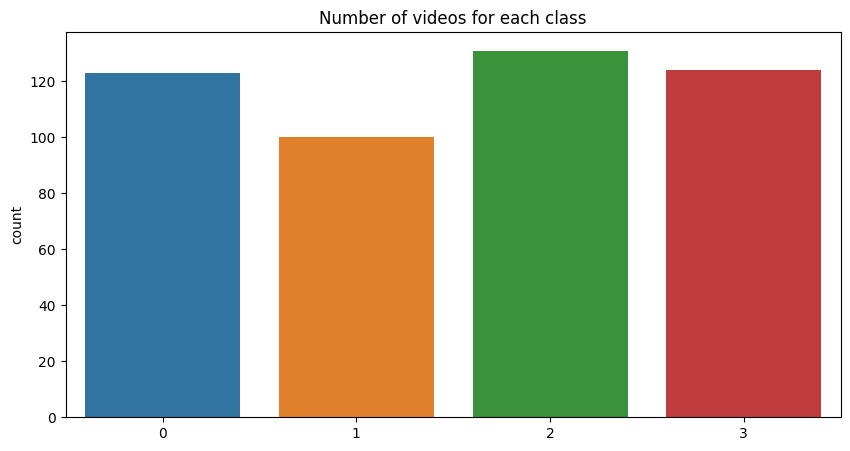

In [57]:
plt.figure(figsize=(10,5))
plt.title('Number of videos for each class')
sns.countplot(x=labels)
